<a href="https://colab.research.google.com/github/jeonghojo00/MachineLearning/blob/main/Feedback_Prize_English_Language_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Problem Definition

1. Source:
    - Kaggle Competition: Feedback Prize - Englilsh Language Learning
2. Goal:
    - To analyze
3. Files
    - 1) sample_submission.csv, 
    - 2) train.csv, 
    - 3) test.csv

2. Source

#1. Data Exploration

## 1_1. Initial Setup

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mount='/content/drive'
drive_root = mount + "/MyDrive/Colab Notebooks/NLP/feedback-prize-english-language-learning"
%cd $drive_root

/content/drive/MyDrive/Colab Notebooks/NLP/feedback-prize-english-language-learning


In [124]:
import sys
import subprocess
import pkg_resources

required = {'transformers', 'datasets', 'torchmetrics', 'contractions', 'evaluate', 'gensim', 'ray[tune]', 'pyspellchecker', 'imbalanced-learn', 'language_tool_python'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [125]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMRegressor
import imblearn

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from transformers import LongformerTokenizer, LongformerModel
from transformers import AdamW, get_scheduler
import re, string, unicodedata
import contractions
import inflect
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
import language_tool_python
import string
import re

nltk.download('stopwords')
grammar_check = language_tool_python.LanguageTool('en-US')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
!pip install language_tool_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1_2. Load Dataset

In [5]:
txtfiles = []
for file in glob.glob("./data/*.csv"):
    txtfiles.append(file)
for i, filename in enumerate(txtfiles):
    print(f"index: {i}, filename: {filename}")

index: 0, filename: ./data/sample_submission.csv
index: 1, filename: ./data/train.csv
index: 2, filename: ./data/test.csv


In [6]:
# Sample submission file
sample_df = pd.read_csv(txtfiles[0])
print("...Displaying Sample Submission")
display(sample_df)

# Train file
train_df = pd.read_csv(txtfiles[1])
print("\n...Displaying Train")
display(train_df)

# Test file
test_df = pd.read_csv(txtfiles[2])
print("\n...Displaying Test")
display(test_df)


...Displaying Sample Submission


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0



...Displaying Train


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5



...Displaying Test


,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


cohesion	
syntax	
vocabulary	
phraseology	
grammar	
conventions

## 1_3. Data Analysis

### 1_3_1. Distributions

In [7]:
print(train_df['cohesion'].value_counts().sort_index())

1.0      10
1.5      27
2.0     315
2.5     790
3.0    1096
3.5     988
4.0     534
4.5     125
5.0      26
Name: cohesion, dtype: int64


In [8]:
# Cohesionn Score distribution
from collections import OrderedDict

def showDistributions(score_type='cohsion'):
    counts = dict(Counter(train_df[score_type]))
    print(f"{score_type} : {OrderedDict(sorted(counts.items()))}")
    plt.figure(figsize = (5,2))
    sns.countplot(x = train_df[score_type], palette = 'Set1', alpha = 0.8)
    plt.title(f'Distribution of {score_type} scores')
    plt.show()

cohesion : OrderedDict([(1.0, 10), (1.5, 27), (2.0, 315), (2.5, 790), (3.0, 1096), (3.5, 988), (4.0, 534), (4.5, 125), (5.0, 26)])


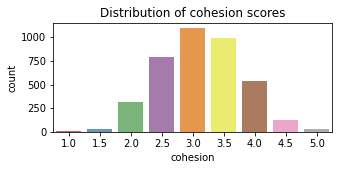

syntax : OrderedDict([(1.0, 11), (1.5, 29), (2.0, 410), (2.5, 839), (3.0, 1250), (3.5, 867), (4.0, 388), (4.5, 100), (5.0, 17)])


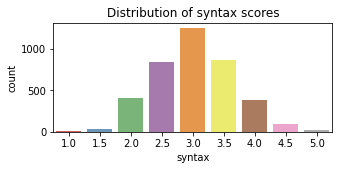

vocabulary : OrderedDict([(1.0, 2), (1.5, 14), (2.0, 124), (2.5, 528), (3.0, 1503), (3.5, 1007), (4.0, 577), (4.5, 115), (5.0, 41)])


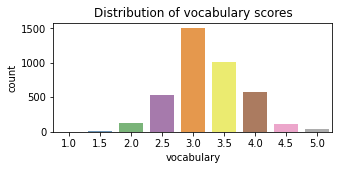

phraseology : OrderedDict([(1.0, 10), (1.5, 11), (2.0, 350), (2.5, 772), (3.0, 1153), (3.5, 929), (4.0, 553), (4.5, 108), (5.0, 25)])


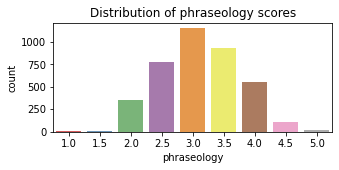

grammar : OrderedDict([(1.0, 8), (1.5, 20), (2.0, 544), (2.5, 855), (3.0, 994), (3.5, 880), (4.0, 447), (4.5, 134), (5.0, 29)])


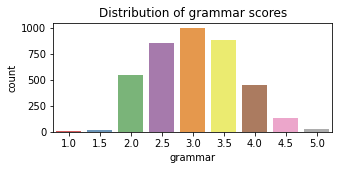

conventions : OrderedDict([(1.0, 15), (1.5, 20), (2.0, 402), (2.5, 784), (3.0, 1151), (3.5, 908), (4.0, 484), (4.5, 122), (5.0, 25)])


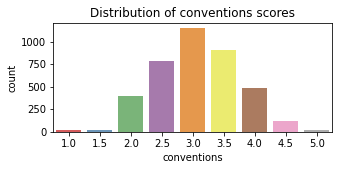

In [9]:
score_types = list(sample_df.columns)[1:]
for score_type in score_types:
    showDistributions(score_type)

In [10]:
# Show word counts distribution
def showWordCounts(df):
    df['word_count'] = df['full_text'].progress_apply(lambda x: len(x.split()))
    maxWords = max(df['word_count'])
    print(f"\nMaximum words in a text is {maxWords}")

    plt.figure(figsize = (15,4))
    sns.histplot(df['word_count'], bins = range(0, 1400, 100), palette = 'Set1', alpha = 0.8)
    plt.title('Distribution of the word count')

    del df['word_count']

100%|██████████| 3911/3911 [00:00<00:00, 43208.36it/s]



Maximum words in a text is 1260


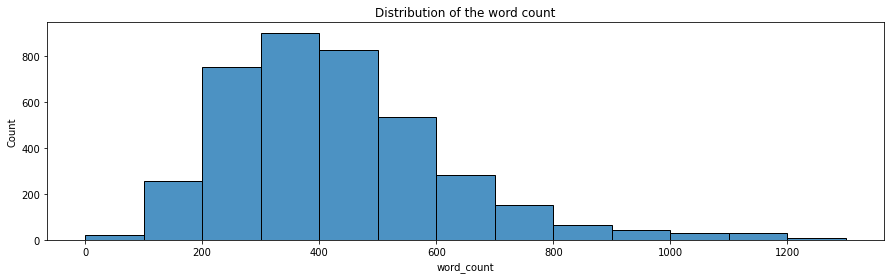

In [11]:
showWordCounts(train_df)

### 1_3_2. Correlation

In [12]:
score_types

['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

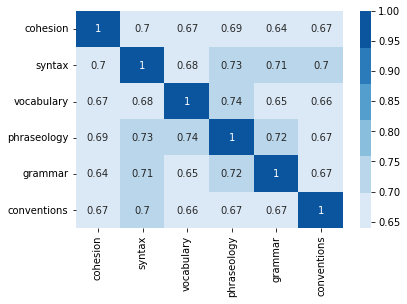

In [13]:
# Defining how required variables correlate to our target variable
corr = train_df[score_types].corr()
colormap = sns.color_palette('Blues')
sns.heatmap(corr, annot=True, cmap=colormap)

#2. Feature Engineering

## 2_1. Feature Engineering

In [14]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Text cleaning
def cleanText(df, toLower=True, removeSquareBrackets=False, removeHyperlink=False, removePuncutation=False, removeNumberWords=False, removeStopwords=False):
    if toLower:
        df.full_text= df.full_text.apply(lambda x:x.lower() )
    if removeSquareBrackets:
        #removing square brackets
        df.full_text= df.full_text.apply(lambda x:re.sub('\[.*?\]', '', x) )
        df.full_text= df.full_text.apply(lambda x:re.sub('<.*?>+', '', x) )
    if removeHyperlink:
        #removing hyperlink
        df.text= df.text.apply(lambda x:re.sub('http[s]?://\S+|www\.\S+', '', x) )
        df.text= df.text.apply(lambda x:replace_contractions(x))
    if removePuncutation:
        #removing puncuation
        df.full_text = df.full_text.apply(lambda x:re.sub(r"[,.;@#?!&$]+\ *", " ", x) )
    if removeNumberWords:
        #remove words containing numbers
        df.text= df.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
    if removeStopwords:
        #remove stopwords
        df.full_text= df.full_text.apply(lambda x: remove_stopwords(x))
    return df

#3. Gradient Boosting

## 3_1. Feature Engineering

### 3_1_1. Vectorize Words

In [ ]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


Use TF-IDF Vectorizer to vectorize words in a sentence

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
'''TF-IDF Vectorizer enables to reduce imporance of the most common words
so that model can penalize words by frequency so that it treats less frequent words more importantly.
Most frequent word -> Most common word -> Most meaningless word like stopwords
'''

vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf = True)
vectorizer.fit(raw_documents=train_df.full_text)

TfidfVectorizer(sublinear_tf=True)

In [ ]:
def extract_vectors(x):
    vecs = vectorizer.transform(x)
    return vecs.toarray().flatten()

# extract_vectors([train.iloc[0].full_text])
train_df['vecs'] = train_df.full_text.progress_apply(lambda x: extract_vectors([x]))
test_df['vecs'] = test_df.full_text.progress_apply(lambda x: extract_vectors([x]))

100%|██████████| 3/3 [00:00<00:00, 585.31it/s]


### 3_1_2. Pull additional features

In [ ]:
def syllable_count(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count


def flesch_kincaid_score(x):
    '206.835 - 1.015 × (total words ÷ total sentences) - 84.6 × (total syllables ÷ total words).'
    total_words = len(x.split())
    total_sentences = (len(x.split('.')))
    syllables = sum([syllable_count(w) for w in x.split()])
    return 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (syllables / total_words)

In [62]:
!pip install language-check

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached language-check-1.1.tar.gz (33 kB)
  ERROR: Failed building wheel for language-check
  Running setup.py clean for language-check
Failed to build language-check
    Running setup.py install for language-check ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-y2sl7bpl/language-check_44683e89069444f591d4e6919c457662/setup.py'"'"'; __file__='"'"'/tmp/pip-install-y2sl7bpl/language-check_44683e89069444f591d4e6919c457662/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-shpmw_as/install-record.txt --single-version-externall

In [60]:
import language_check
tool = language_check.LanguageTool('en-US')
text = u'A sentence with a error in the Hitchhiker’s Guide tot he Galaxy'
matches = tool.check(text)
len(matches)

ModuleNotFoundError: ignored

Flesch–Kincaid readability tests
- indicates how difficult a passage in English is to understand.
- 206.835 - 1.015 * (total words / total sentences) - 84.6 * (total syllables / total words)
- lower the harder to understand

In [ ]:
# extract features from text
stop_words = stopwords.words('english')

def feature_creations(df):
    df['char_count'] = df['full_text'].progress_apply(len)
    df['word_count'] = df['full_text'].progress_apply(lambda x: len(x.split()))
    df['word_density'] = df['char_count'] / (df['word_count'] + 1)
    df['punctuation_count'] = df['full_text'].progress_apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    df['title_word_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    df['upper_case_word_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    df['stopword_count'] = df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
    df['flesch_kincaid_score'] = df['full_text'].progress_apply(lambda x: flesch_kincaid_score(x))
    return df

train_df['char_count'] = train_df['full_text'].progress_apply(len)
train_df['word_count'] = train_df['full_text'].progress_apply(lambda x: len(x.split()))
train_df['word_density'] = train_df['char_count'] / (train_df['word_count'] + 1)
train_df['punctuation_count'] = train_df['full_text'].progress_apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train_df['title_word_count'] = train_df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train_df['upper_case_word_count'] = train_df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
train_df['stopword_count'] = train_df['full_text'].progress_apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
train_df['flesch_kincaid_score'] = train_df['full_text'].progress_apply(lambda x: flesch_kincaid_score(x))

100%|██████████| 3911/3911 [00:02<00:00, 1495.94it/s]


In [ ]:
test_df = feature_creations(test_df)

100%|██████████| 3/3 [00:00<00:00, 953.97it/s]


In [ ]:
eng_features = train_df.drop(['text_id', 'full_text', 'cohesion','syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'vecs'], axis=1).columns

### 3_1_3. Normalize

In [ ]:
# Normalize X
from sklearn.preprocessing import StandardScaler
scaled_train_df = train_df.copy()
scaled_test_df = test_df.copy()

scaler = StandardScaler()
scaled_train_df[list(eng_features)] = scaler.fit_transform(scaled_train_df[list(eng_features)])
scaled_test_df[list(eng_features)] = scaler.transform(scaled_test_df[list(eng_features)])

In [ ]:
# Flatten Each Row
def flattenRows(df):
    '''
    Make a X dataset combining a list of word vectors and other infomrative features such as 
    char counts, word counts, ..., and flesch_kincaid_score.
    '''
    features_set = []

    for index, row in tqdm(df.iterrows(), total=len(df)):
        text_vecs = row['vecs']
        other_features = row[eng_features].values.astype(float)
        features_set.append(np.append(text_vecs, other_features))

    X = np.array(features_set)   
    return X

In [ ]:
scaled_X = flattenRows(scaled_train_df)
X = flattenRows(train_df)
scaled_test_X = flattenRows(scaled_test_df)

100%|██████████| 3/3 [00:00<00:00, 1308.95it/s]


In [ ]:
scores = {}
for score_type in score_types:
    scores[score_type] = train_df[score_type].values

In [ ]:
scores

{'cohesion': array([3.5, 2.5, 3. , ..., 2.5, 4. , 3.5]),
 'syntax': array([3.5, 2.5, 3.5, ..., 3. , 4.5, 2.5]),
 'vocabulary': array([3. , 3. , 3. , ..., 3. , 4.5, 3.5]),
 'phraseology': array([3., 2., 3., ..., 3., 4., 3.]),
 'grammar': array([4. , 2. , 3. , ..., 3.5, 4.5, 3. ]),
 'conventions': array([3. , 2.5, 2.5, ..., 3. , 4.5, 3.5])}

## 3_2. Gradient Boosting Regression

In [ ]:
def showDisributions(data, title=None):
    counts = dict(Counter(data))
    print(f"Data counts : {OrderedDict(sorted(counts.items()))}")
    plt.figure(figsize = (5,2))
    sns.countplot(x = data, palette = 'Set1', alpha = 0.8)
    plt.title(f'{title} Distributions')
    plt.show()    

### 3_2_1. Find Optimal Parameters for LGBM Regressor

In [ ]:
from lightgbm import LGBMRegressor, LGBMClassifier
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.metrics import f1_score, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from statistics import mean
import pickle

rmse_scorer = make_scorer(mean_squared_error , squared=False)

test_params ={'boosting_type': ['gbdt', 'dart'],
             'num_leaves': [30, 100, 200], 
             'max_depth' : [5, 7, 10, 15],
             'learning_rate' : [0.1, 0.05, 0.01],
             'n_estimators': [1000, 5000],
             'subsample': [0.5, 0.7, 1.0], 
             'colsample_bytree': [0.5, 0.7, 1.0],
             'reg_alpha': [0, 1e-1, 5e-1, 1, 10],
             'reg_lambda': [0, 1e-1, 5e-1, 1, 10]}


#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

In [ ]:
lgbmReg_optim = dict()
rmse_scores = list()
file2save = 'rmse_'+str(np.mean(rmse_scores).item())+'_LGBMRegressor_optim_params.pkl'

for score_type in tqdm(score_types):
    model = LGBMRegressor(random_state=42, n_jobs=-1)
    cv= KFold(n_splits=5, shuffle=True, random_state=42)
    gs = RandomizedSearchCV(
        estimator=model, 
        param_distributions=test_params, 
        n_iter=n_HP_points_to_test,
        scoring=rmse_scorer,
        cv=cv,
        refit=True,
        verbose=1)

    gs.fit(scaled_X, scores[score_type])
    print('{}: Best score reached: {} with params: {} '.format(score_type, gs.best_score_, gs.best_params_))
    lgbmReg_optim[score_type] = gs.best_params_
    rmse_scores.append(gs.best_score_)

    # create a binary pickle file 
    f = open(file2save,"wb")
    pickle.dump(lgbmReg_optim,f)
    print(f'{file2save} saved')
    f.close()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


 17%|█▋        | 1/6 [6:25:51<32:09:17, 23151.43s/it]

cohesion: Best score reached: 3.2937436929293553 with params: {'subsample': 0.5, 'reg_lambda': 10, 'reg_alpha': 1, 'num_leaves': 30, 'n_estimators': 5000, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'boosting_type': 'dart'} 
rmse_nan_LGBMRegressor_optim_params.pkl saved
Fitting 5 folds for each of 100 candidates, totalling 500 fits


 33%|███▎      | 2/6 [11:50:15<23:18:49, 20982.31s/it]

syntax: Best score reached: 3.080429522324505 with params: {'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 10, 'num_leaves': 100, 'n_estimators': 5000, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'boosting_type': 'dart'} 
rmse_nan_LGBMRegressor_optim_params.pkl saved
Fitting 5 folds for each of 100 candidates, totalling 500 fits


 50%|█████     | 3/6 [16:41:39<16:09:14, 19384.78s/it]

vocabulary: Best score reached: 3.415112626453886 with params: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 10, 'num_leaves': 30, 'n_estimators': 5000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7, 'boosting_type': 'dart'} 
rmse_nan_LGBMRegressor_optim_params.pkl saved
Fitting 5 folds for each of 100 candidates, totalling 500 fits


### 3_2_2. Train and predict

In [ ]:
filename = 'rmse_nan_LGBMRegressor_optim_params.pkl'
infile = open(filename,'rb')
lgbmReg_params = pickle.load(infile)
infile.close()

In [ ]:
def evaluate_model(model, X, y, cv, flag='regression'):
    results = dict()    
    if flag == 'regression':
        mae = cross_val_score(model, X, y, cv = cv, scoring='neg_mean_absolute_error')
        mse = cross_val_score(model, X, y, cv = cv, scoring='neg_mean_squared_error')
        rmse = cross_val_score(model, X, y, cv = cv, scoring='neg_root_mean_squared_error')
        r2 = cross_val_score(model, X, y, cv = cv, scoring='r2')
        results['MAE'] = abs(np.mean(mae))
        results['MSE'] = abs(np.mean(mse))
        results['RMSE'] = abs(np.mean(rmse))
        results['R2'] = abs(np.mean(r2))
    else:
        f1 = cross_val_score(model, X, y, cv = cv, scoring='f1_weighted')
        roc_auc = cross_val_score(model, X, y, cv = cv, scoring='roc_auc_ovo_weighted')
        results['f1'] = abs(np.mean(f1))
        results['ROC_AUC'] = abs(np.mean(roc_auc))
    return results

In [ ]:
score_type = 'cohesion'
optim_param = lgbmReg_params[score_type]
model = LGBMRegressor(**optim_param)
cv= KFold(n_splits=5, shuffle=True)
eval_results = evaluate_model(model, scaled_X, scores[score_type], cv, flag='regression')
display(eval_results)

{'MAE': 3.462863367944462,
 'MSE': 11.441278628585891,
 'RMSE': 3.264097760437277,
 'R2': 28.10810283383409}

In [ ]:
score_type = 'cohesion'
model = LGBMRegressor()
cv= KFold(n_splits=5, shuffle=True)
eval_results = evaluate_model(model, scaled_X, scores[score_type], cv, flag='regression')
display(eval_results)

{'MAE': 0.4504556952342148,
 'MSE': 0.3060366702769185,
 'RMSE': 0.5480434278172966,
 'R2': 0.3030241128201774}

In [ ]:
score_type = 'cohesion'
model = LGBMRegressor()
cv= KFold(n_splits=5, shuffle=True)
eval_results = evaluate_model(model, X, scores[score_type], cv, flag='regression')
display(eval_results)

{'MAE': 0.4455762179590995,
 'MSE': 0.3045563447311723,
 'RMSE': 0.5549702606347953,
 'R2': 0.30146783006933536}

In [ ]:
LGBM_results = dict()
LGBM_results['regression'] = dict()

In [ ]:
# LGBM Regression
for score_type in score_types:
    model = LGBMRegressor()
    cv= KFold(n_splits=5, shuffle=True)
    LGBM_results['regression'][score_type] = evaluate_model(model, X, scores[score_type], cv, 'regression')

display(LGBM_results)

In [ ]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, scores['cohesion'], test_size=0.2, random_state=42)
lgbmReg = LGBMRegressor()
lgbmReg.fit(X_train, y_train)
y_pred = lgbmReg.predict(X_test)

In [ ]:
def round_to_scale(predictions):
    rounded = list()
    for val in predictions:
        if val < 1.25:
            rounded.append(1.0)
        elif val < 1.75:
            rounded.append(1.5)
        elif val < 2.25:
            rounded.append(2.0)
        elif val < 2.75:
            rounded.append(2.5)
        elif val < 3.25:
            rounded.append(3.0)
        elif val < 3.75:
            rounded.append(3.5)
        elif val < 4.25:
            rounded.append(4.0)
        elif val < 4.75:
            rounded.append(4.5)
        else:
            rounded.append(5.0)
    return np.array(rounded)


In [ ]:
rounded_y = round_to_scale(y_pred)

In [ ]:
mean_squared_error(y_test, y_pred, squared=False)

0.5440929703972038

cohesion	
syntax	
vocabulary	
phraseology	
grammar	
conventions

In [ ]:
test_df

,text_id,full_text,vecs,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,flesch_kincaid_score
0,0000C359D63E,when a person has no experience on a job their...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4224,835,5.052632,37,25,1,454,67.346130
1,000BAD50D026,Do you think students would benefit from being...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2167,386,5.599483,36,11,1,207,67.940871
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2361,442,5.329571,33,11,1,244,62.349525


In [ ]:
for score_type in score_types:
    model = LGBMRegressor()
    model.fit(scaled_X, scores[score_type])
    test_df[score_type] = model.predict(scaled_test_X)

In [ ]:
test_df

,text_id,full_text,vecs,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,flesch_kincaid_score,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4224,835,5.052632,37,25,1,454,67.346130,3.257816,3.053141,3.416932,3.264194,2.924972,2.966888
1,000BAD50D026,Do you think students would benefit from being...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2167,386,5.599483,36,11,1,207,67.940871,2.946341,3.039620,2.993347,2.734318,2.746865,3.140122
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2361,442,5.329571,33,11,1,244,62.349525,3.577981,3.268005,3.358719,3.285543,3.405709,3.122653


In [ ]:
submission_cols = ['text_id'] + score_types
submission = test_df[submission_cols]
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.257816,3.053141,3.416932,3.264194,2.924972,2.966888
1,000BAD50D026,2.946341,3.039620,2.993347,2.734318,2.746865,3.140122
2,00367BB2546B,3.577981,3.268005,3.358719,3.285543,3.405709,3.122653


In [ ]:
sample_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
submission.to_csv("submission.csv", index=False)

## 3_3. Gradient Boosting Classification

In [ ]:
# Apply Label encoder for scores for Classification
label_encoders = dict()
scores4clf = dict()
for score_type in score_types:
    label_encoders[score_type] = LabelEncoder()
    train_df[score_type+'_le'] = label_encoders['cohesion'].fit_transform(train_df[score_type])
    scores4clf[score_type] = train_df[score_type+'_le']

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, scores4clf['cohesion'], test_size=0.2, random_state=42)

# Oversample for train data for imbalanced status
oversample = RandomOverSampler()
X_train_ros, y_train_ros = oversample.fit_resample(X_train, y_train)

y_train_counts = dict(Counter(y_train))
print(y_train_counts)

{6: 431, 5: 769, 2: 253, 4: 881, 3: 639, 7: 106, 8: 21, 1: 20, 0: 8}


Data counts : OrderedDict([(0, 8), (1, 20), (2, 253), (3, 639), (4, 881), (5, 769), (6, 431), (7, 106), (8, 21)])


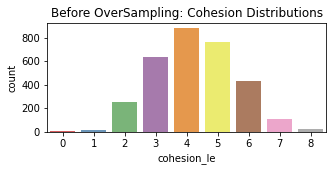

Data counts : OrderedDict([(0, 881), (1, 881), (2, 881), (3, 881), (4, 881), (5, 881), (6, 881), (7, 881), (8, 881)])


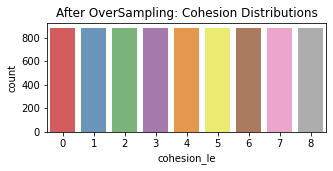

In [ ]:
showDisributions(y_train, title='Before OverSampling: Cohesion')
showDisributions(y_train_ros, title='After OverSampling: Cohesion')

### 3_3_1. Find Optimal Parameters for LGBM classifier

Data counts : OrderedDict([(0, 2), (1, 7), (2, 62), (3, 151), (4, 215), (5, 219), (6, 103), (7, 19), (8, 5)])


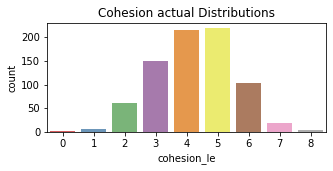

Data counts : OrderedDict([(0, 1), (1, 8), (2, 25), (3, 143), (4, 269), (5, 241), (6, 86), (7, 6), (8, 4)])


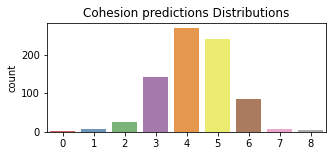

0.2614478446427929


In [ ]:
model = LGBMClassifier()
model.fit(X_train_ros, y_train_ros)
y_pred = model.predict(X_test)
#y_pred = label_encoders['cohesion'].inverse_transform(y_pred)

showDisributions(y_test, title='Cohesion actual')
showDisributions(y_pred, title='Cohesion predictions')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

In [ ]:
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.metrics import f1_score, make_scorer

def evaluate_weightedF1_lgb(truth, predictions):
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return "weightedF1", f1, True

f1_scorer = make_scorer(f1_score , average='weighted')

param_test ={'boosting_type': ['gbdt', 'rf'],
             'num_leaves': sp_randInt(6, 50), 
             'max_depth' : [-1],
             'learning_rate' : sp_randFloat(),
             'n_estimators': [1000, 5000],
             'objective': ['multiclass'], #'multiclass for multi-class classificaiton
             'min_child_samples': sp_randInt(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_randFloat(), 
             'colsample_bytree': sp_randFloat(),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

clf = LGBMClassifier(class_weight = y_train_counts,
                     random_state=42, 
                     n_jobs=-1)
cv= KFold(n_splits=5, shuffle=True, random_state=42)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring=f1_scorer,
    cv=cv,
    refit=True,
    random_state=42,
    verbose=True)

In [ ]:
gs.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
220 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
220 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 744, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/sklearn.py", line 544, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    bo

Best score reached: 0.29658998049052604 with params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.5527649668354899, 'learning_rate': 0.5722924691708383, 'max_depth': -1, 'min_child_samples': 287, 'min_child_weight': 1e-05, 'n_estimators': 5000, 'num_leaves': 26, 'objective': 'multiclass', 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.31692200515627766} 


In [ ]:
lgbmClf_params = dict()
lgbmClf_params['cohesion'] = {'boosting_type': 'gbdt', 
                              'colsample_bytree': 0.5527649668354899, 
                              'learning_rate': 0.5722924691708383, 
                              'max_depth': -1, 'min_child_samples': 287, 
                              'min_child_weight': 1e-05, 
                              'n_estimators': 5000, 
                              'num_leaves': 26, 
                              'objective': 'multiclass', 
                              'reg_alpha': 10, 
                              'reg_lambda': 0, 
                              'subsample': 0.31692200515627766}

Data counts : OrderedDict([(0, 2), (1, 7), (2, 62), (3, 151), (4, 215), (5, 219), (6, 103), (7, 19), (8, 5)])


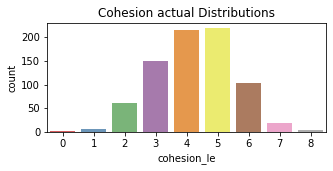

Data counts : OrderedDict([(1, 1), (2, 35), (3, 161), (4, 257), (5, 234), (6, 88), (7, 7)])


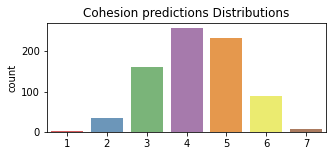

Cohesion f1 score:  0.2631418493209135


In [ ]:
model = LGBMClassifier(**lgbmClf_params['cohesion'])
model.fit(X_train_ros, y_train_ros)
y_pred = model.predict(X_test)
#y_pred = label_encoders['cohesion'].inverse_transform(y_pred)

showDisributions(y_test, title='Cohesion actual')
showDisributions(y_pred, title='Cohesion predictions')

from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Cohesion f1 score: ", f1)

#4. BERT

In [15]:
counts = dict(Counter(train_df['cohesion']))
scores = sorted(list(counts.keys()))
print(scores)
id2label = {k:scores[k] for k in range(len(scores))}
label2id = {scores[k]:k for k in range(len(scores))}
print(id2label)
print(label2id)

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
{0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5, 4: 3.0, 5: 3.5, 6: 4.0, 7: 4.5, 8: 5.0}
{1.0: 0, 1.5: 1, 2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6, 4.5: 7, 5.0: 8}


In [78]:
import torch
'''
model types:
1) allenai/longformer-base-4096
2) bert-base-cased
3) bert-base-multilingual-cased
'''

config = {
    'model': 'allenai/longformer-base-4096',
    'dropout': 0.5,
    'max_length': int(512),
    'batch_size': 8,
    'epochs': 5,
    'lr': 5e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'CosineAnnealingWarmRestarts',
    'toLower' : True,
    'removeSquareBrackets': False,
    'removeHyperlink' : False,
    'removePuncutation' : True,
    'removeNumberWords' : False,
    'removeStopwords' : True
}

In [79]:
cleaned_train = train_df.copy()
cleaned_test = test_df.copy()

cleaned_train = cleanText(cleaned_train, 
                          toLower=config['toLower'], 
                          removeSquareBrackets=config['removeSquareBrackets'], 
                          removeHyperlink=config['removeHyperlink'], 
                          removePuncutation=config['removePuncutation'], 
                          removeNumberWords=config['removeNumberWords'], 
                          removeStopwords=config['removeStopwords'])

cleaned_test = cleanText(cleaned_test, 
                          toLower=config['toLower'], 
                          removeSquareBrackets=config['removeSquareBrackets'], 
                          removeHyperlink=config['removeHyperlink'], 
                          removePuncutation=config['removePuncutation'], 
                          removeNumberWords=config['removeNumberWords'], 
                          removeStopwords=config['removeStopwords'])

100%|██████████| 3911/3911 [00:00<00:00, 91577.05it/s]



Maximum words in a text is 480


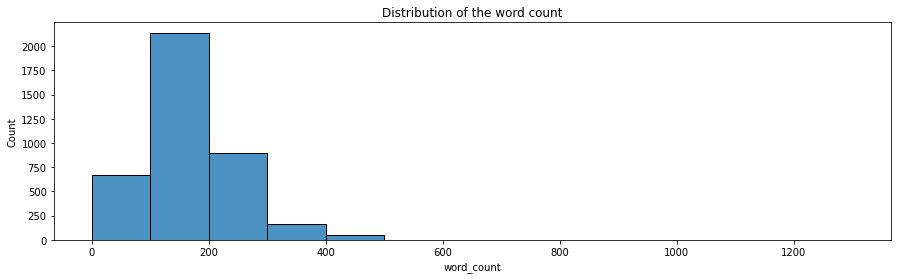

In [80]:
# Only to Lower
showWordCounts(cleaned_train)

100%|██████████| 3911/3911 [00:00<00:00, 94756.28it/s]



Maximum words in a text is 480


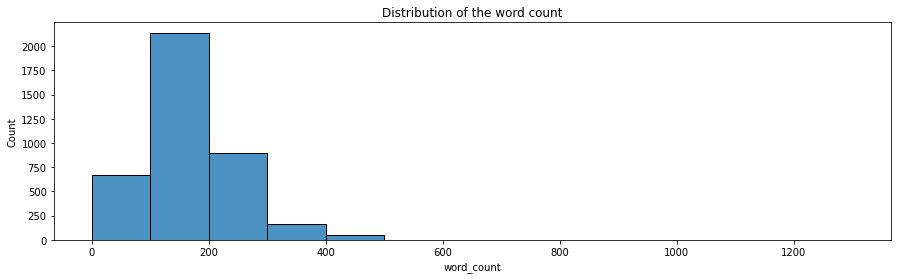

In [81]:
# After removal of stopwords
showWordCounts(cleaned_train)

In [82]:
# Train and Validation Split
from sklearn.model_selection import train_test_split

train, val = train_test_split(cleaned_train, test_size = 0.2, shuffle=True)
print('dataframe shapes:',train.shape, val.shape)

dataframe shapes: (3128, 8) (783, 8)


In [104]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AutoTokenizer, AutoModel
model1 = 'distilbert-base-uncased'
model1 = 'bert-base-uncased'
model = AutoModel.from_pretrained(model1)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [100]:
model.config.hidden_size

768

In [102]:
model1 = "bert-base-uncased"
if 'distilbert' in model1:
    print('yes')

In [83]:
import torch
import torch.nn as nn
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AutoTokenizer

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class EssayClassification(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EssayClassification, self).__init__()
        self.model_name = config['model']
        self.encoder = LongformerModel.from_pretrained(self.model_name)
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, inputs):
        _, outputs = self.encoder(**inputs, return_dict=False)
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

In [84]:
# For one hot-encoding for each score type
# model = LongformerForSequenceClassification.from_pretrained(config['model'], id2label=id2label, label2id=label2id)
# model.classifier.dropout = torch.nn.Dropout(p = config['dropout'])

# When predicting for all
model = EssayClassification(config, num_classes=6)
tokenizer = LongformerTokenizer.from_pretrained(config['model'])

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [85]:
class EssayDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=True,
                                          padding='max_length',
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            #"token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        targets = {
            "labels": torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)

In [86]:
train_ds = EssayDataset(train, config, tokenizer=tokenizer)
val_ds = EssayDataset(val, config, tokenizer=tokenizer)
test_ds = EssayDataset(cleaned_test, config, tokenizer=tokenizer, is_test=True)

In [87]:
print(train.columns.to_list())

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


In [88]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )
test_loader = torch.utils.data.DataLoader(test_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )

print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 391 98


In [89]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        :param val: value from the scores
        :param n  : batch_size
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [90]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.metrics = {}
        self.metrics['train_losses'] = []
        self.metrics['val_losses'] = []

        self.optimizer = self._get_optim()
        self.schedulers = {
            'CosineAnnealingWarmRestarts': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=5),
            'StepLR': torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2, gamma=0.1),
            'ReduceLROnPlateau': torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer)
        }
        self.scheduler = self.schedulers[self.config['scheduler']]
    
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'])
        return optimizer
    
    def fit(self):
        EPOCHS = self.config['epochs']
        for epoch in range(1, EPOCHS+1):
            print(f"\n Epoch: {epoch} / {EPOCHS}")
            self.train(epoch)
            self.validate(epoch)
            print(f"Train Loss: {self.metrics['train_losses'][-1]:.2} / Val Loss: {self.metrics['val_losses'][-1]:.2}")

    def loss_fn(self, outputs, targets):
            colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
            loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
            return loss

    def train(self, epoch):
        self.model.train()
        losses = AverageMeter()
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        iters = len(self.train_loader)

        for i,(inputs,targets) in enumerate(progress):
            # Initiate
            self.optimizer.zero_grad()
            inputs = {k:inputs[k].to(device=self.config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=self.config['device']) 

            # Forward
            outputs = self.model(inputs)
            
            # Get Loss
            loss = self.loss_fn(outputs, targets)
            losses.update(loss.item(), len(targets))

            # Back Prop.
            loss.backward()

            # Update Weights
            self.optimizer.step()
            if self.config['scheduler'] == 'CosineAnnealingWarmRestarts':
                self.scheduler.step(epoch-1 + i / iters)
            elif self.config['scheduler'] == 'StepLR':
                self.scheduler.step()
        self.metrics['train_losses'].append(losses.avg)

    def validate(self, epoch):
        self.model.eval()
        losses = AverageMeter()
        progress = tqdm(self.val_loader, total=len(self.val_loader))

        with torch.no_grad():

            for i,(inputs,targets) in enumerate(progress):
                # Forward
                inputs = {k:inputs[k].to(device=self.config['device']) for k in inputs.keys()}
                targets = targets['labels'].to(device=self.config['device']) 

                # Forward
                outputs = self.model(inputs)

                # Get Loss
                loss = self.loss_fn(outputs, targets)
                losses.update(loss.item(), len(targets))

                # Keep track of metrics
                if self.config['scheduler'] == 'ReduceLROnPlateau':
                    self.scheduler.step(loss)
        self.metrics['val_losses'].append(losses.avg)

    def predict(self, test_loader):
        preds = []
        for (inputs) in test_loader:
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds

In [91]:
model = model.to(device=config['device'])
trainer = Trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    config = config
)

In [92]:
trainer.fit()


 Epoch: 1 / 20


100%|██████████| 98/98 [00:08<00:00, 11.31it/s]


Train Loss: 0.75 / Val Loss: 0.64

 Epoch: 2 / 20


100%|██████████| 98/98 [00:08<00:00, 11.33it/s]


Train Loss: 0.69 / Val Loss: 0.63

 Epoch: 3 / 20


100%|██████████| 98/98 [00:08<00:00, 11.29it/s]


Train Loss: 0.68 / Val Loss: 0.63

 Epoch: 4 / 20


100%|██████████| 98/98 [00:08<00:00, 11.32it/s]


Train Loss: 0.66 / Val Loss: 0.62

 Epoch: 5 / 20


100%|██████████| 98/98 [00:08<00:00, 11.30it/s]


Train Loss: 0.67 / Val Loss: 0.63

 Epoch: 6 / 20


100%|██████████| 98/98 [00:08<00:00, 11.25it/s]


Train Loss: 0.69 / Val Loss: 0.65

 Epoch: 7 / 20


100%|██████████| 98/98 [00:08<00:00, 11.33it/s]


Train Loss: 0.68 / Val Loss: 0.64

 Epoch: 8 / 20


 13%|█▎        | 49/391 [00:18<02:10,  2.62it/s]


KeyboardInterrupt: ignored

In [ ]:
# Show Loss Curve (Only to lower)
epoch_range = list(range(1, config['epochs']+1))

plt.plot(epoch_range, trainer.metrics['train_losses'], label='Train Loss')
plt.plot(epoch_range, trainer.metrics['val_losses'], label='Val Loss')
plt.title('Train and Validation Loss')
plt.legend(loc='best')
plt.xticks(ticks=epoch_range)
plt.show()

In [ ]:
# Show Loss Curve (after removal of stopwords)
epoch_range = list(range(1, config['epochs']+1))

plt.plot(epoch_range, trainer.metrics['train_losses'], label='Train Loss')
plt.plot(epoch_range, trainer.metrics['val_losses'], label='Val Loss')
plt.title('Train and Validation Loss')
plt.legend(loc='best')
plt.xticks(ticks=epoch_range)
plt.show()

In [ ]:
preds = trainer.predict(test_loader)

In [ ]:
preds.shape

torch.Size([3, 6])

In [ ]:
preds

tensor([[3.4489, 3.2800, 3.5260, 3.4143, 3.3714, 3.3931],
        [3.1118, 2.9416, 3.2360, 3.1018, 3.0323, 3.0270],
        [2.8983, 2.7325, 3.0455, 2.9095, 2.8270, 2.7471]])

In [ ]:
result = dict(config)
result['val_loss'] = min(trainer.metrics['val_losses'])
result

{'model': 'allenai/longformer-base-4096',
 'dropout': 0.5,
 'max_length': 512,
 'batch_size': 8,
 'epochs': 1,
 'lr': 2e-05,
 'device': 'cuda',
 'scheduler': 'CosineAnnealingWarmRestarts',
 'toLower': True,
 'removeSquareBrackets': False,
 'removeHyperlink': False,
 'removePuncutation': False,
 'removeNumberWords': False,
 'removeStopwords': True,
 'val_loss': 0.5135705526228305}

In [ ]:
# Save results
import pickle

with open('filename.pickle', 'wb') as handle:
    pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(a == b)

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model_name = 'longformer'
task = "feedback_prize"

LEARNING_RATE = 5e-6
BATCH_SIZE = 8
EPOCHS = 1

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-{task}",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3128
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 391
Initializing global attention on CLS token...


ValueError: ignored